In [1]:
#!pip3 install pyaml 

In [2]:
#from collections import defaultdict
#import itertools
#import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import yaml
import os
from coco import COCO
import json
import glob


In [3]:
# Read YAML file
with open("configDNVdata.yaml", 'r') as stream:
    config_file = yaml.safe_load(stream)

DATASET_DIR = config_file['dataset_src_dir']
    
TRAIN_PATH = os.path.join(DATASET_DIR, config_file['train'])
VAL_PATH = os.path.join(DATASET_DIR, config_file['val'])
TEST_PATH = os.path.join(DATASET_DIR, config_file['test'])

SIMULATION_SCENARIOS = os.listdir(DATASET_DIR)
MERGE_CLASSES = True

CREATE_JSON_COCO=True

In [4]:
SIMULATION_SCENARIOS = ['2023-05-09_1257_dnv_scenario1_full_00_000_AfternoonClear',
                        '2023-05-09_1300_dnv_scenario1_full_00_000_AfternoonCloudy',
                        '2023-05-09_1302_dnv_scenario1_full_00_000_AfternoonCloudy_Rain',                          
                        '2023-05-09_1308_dnv_scenario1_full_00_000_EveningClear',         
                        '2023-05-09_1311_dnv_scenario1_full_00_000_EveningCloudy',         
                        '2023-05-09_1313_dnv_scenario1_full_00_000_EveningCloudy_Rain',         
                        '2023-05-09_1315_dnv_scenario1_full_00_000_FoggyClear',         
                        '2023-05-09_1317_dnv_scenario1_full_00_000_FoggyCloudy',         
                        '2023-05-09_1319_dnv_scenario1_full_00_000_MorningClear',         
                        '2023-05-09_1321_dnv_scenario1_full_00_000_MorningCloudy',         
                        '2023-05-09_1324_dnv_scenario1_full_00_000_NightClear',         
                        '2023-05-09_1326_dnv_scenario1_full_00_000_NightCloudy',         
                        '2023-05-09_1328_dnv_scenario1_full_00_000_NoonClear',         
                        '2023-05-09_1330_dnv_scenario1_full_00_000_NoonCloudy',         
                        '2023-05-09_1332_dnv_scenario1_full_00_000_NoonCloudy_Rain',         
                        '2023-05-09_1335_dnv_scenario1_full_00_000_Overcast',                 
                        '2023-05-09_1339_dnv_scenario1_full_00_000_StormClouds',         
                        '2023-05-09_1341_dnv_scenario1_full_00_000_StormyClouds_Rain']

In [5]:
SIMULATION_SCENARIOS = ['2023-05-12_1427_dnv_scenario1_full_00_000_AfternoonClear_absoluteCalmBlueSea',    
                        '2023-05-12_1429_dnv_scenario1_full_00_000_AfternoonCloudy_absoluteCalmBlueSea',    
                        '2023-05-12_1431_dnv_scenario1_full_00_000_AfternoonCloudy_Rain_absoluteCalmBlueSea',       
                        '2023-05-12_1437_dnv_scenario1_full_00_000_EveningClear_absoluteCalmBlueSea',    
                        '2023-05-12_1439_dnv_scenario1_full_00_000_EveningCloudy_absoluteCalmBlueSea',    
                        '2023-05-12_1442_dnv_scenario1_full_00_000_EveningCloudy_Rain_absoluteCalmBlueSea',    
                        '2023-05-12_1444_dnv_scenario1_full_00_000_FoggyClear_absoluteCalmBlueSea',    
                        '2023-05-12_1446_dnv_scenario1_full_00_000_FoggyCloudy_absoluteCalmBlueSea',    
                        '2023-05-12_1450_dnv_scenario1_full_00_000_MorningCloudy_absoluteCalmBlueSea',    
                        '2023-05-12_1448_dnv_scenario1_full_00_000_MorningClear_absoluteCalmBlueSea',    
                        '2023-05-12_1452_dnv_scenario1_full_00_000_NightClear_absoluteCalmBlueSea',    
                        '2023-05-12_1454_dnv_scenario1_full_00_000_NightCloudy_absoluteCalmBlueSea',    
                        '2023-05-12_1456_dnv_scenario1_full_00_000_NoonClear_absoluteCalmBlueSea',    
                        '2023-05-12_1458_dnv_scenario1_full_00_000_NoonCloudy_absoluteCalmBlueSea',    
                        '2023-05-12_1500_dnv_scenario1_full_00_000_NoonCloudy_Rain_absoluteCalmBlueSea',    
                        '2023-05-12_1502_dnv_scenario1_full_00_000_Overcast_absoluteCalmBlueSea',    
                        '2023-05-12_1504_dnv_scenario1_full_00_000_OvercastRandomize_absoluteCalmBlueSea',    
                        '2023-05-12_1506_dnv_scenario1_full_00_000_StormClouds_absoluteCalmBlueSea',    
                        '2023-05-12_1508_dnv_scenario1_full_00_000_StormyClouds_Rain_absoluteCalmBlueSea'
                        ]





In [6]:
CURRENT_SCENARIO_PATH = os.path.join(DATASET_DIR, SIMULATION_SCENARIOS[9])
IMAGES_PATH = os.path.join(CURRENT_SCENARIO_PATH, 'images/')



In [7]:
def make_coco_imagelist(folderpath):
    image_paths = glob.glob(f'{folderpath}/*.jpg')
    images = []
    for image_path in image_paths:
        height = 2056
        width = 2464
        filename = image_path.split('/')[-1]
        image_id = filename.split('.')[0]
        images.append({'filename':filename, 'height':height, 'width': width,  'id': image_id})
    return images

def convert_bb(bb):
    x_left, y_bottom = bb[0].values()
    x_right, y_top = bb[1].values()
    width = x_right - x_left
    height = y_top - y_bottom

    return [round(x_left), round(y_bottom), round(width), round(height)]

def make_coco_annot_list(folderpath, merge_classes=True):
    annotation_paths = glob.glob(f'{folderpath}/*.json')

    categories = []
    categories_coco = []
    annots_coco = []
    if merge_classes:
        categories_coco = [{"supercategory": "none",
                                            "id": 0,
                                            "name": 'boat'}]
    for annot_path in annotation_paths:
        image_id = annot_path.split('/')[-1].split('.')[0]
        with open(annot_path, 'r') as data_file:
            json_data = data_file.read()

        data = json.loads(json_data)
        for i, annot in enumerate(data):
            annot_id = image_id+f'_{i}'
            bbox = convert_bb(annot['BB2D'])
            area = bbox[2]*bbox[3] # width*height
            if not merge_classes:
                alias = annot['Alias']
                if alias not in categories: 
                    categories_coco.append({"supercategory": "none",
                                            "id": len(categories),
                                            "name": alias})
                    categories.append(alias)
                category_id = categories.index(alias)
            else:
                category_id = 0

            annot_coco_format = {'area': area, 'iscrowd': 0, 'bbox': bbox, 'category_id': category_id, 'segmentation': [], 'image_id': image_id, 'id': annot_id}
            annots_coco.append(annot_coco_format)
    return annots_coco, categories_coco

In [8]:
if CREATE_JSON_COCO:
    ttype = "instances"
    for folder in SIMULATION_SCENARIOS:
        if folder.split('.')[-1] == 'png': continue
        if folder.split('.')[-1] == 'txt': continue
        if folder.split('.')[-1] == 'cache': continue

        visual_data_folder = os.path.join(os.path.join(DATASET_DIR, folder), 'images/')
        images = make_coco_imagelist(visual_data_folder)
        annots_coco, categories = make_coco_annot_list(visual_data_folder)

        coco_json_dict = {'images':images, 'type': ttype, 'annotations': annots_coco, 'categories': categories}
        
        out_path = os.path.join(os.path.join(DATASET_DIR, folder), 'coco.json')
        with open(out_path, 'w+') as outfile:
            json.dump(coco_json_dict, outfile, indent=4)

In [9]:
dataset_path = os.path.join(CURRENT_SCENARIO_PATH, 'coco.json')
data = COCO(dataset_path)
CLASSES = {id: cat['name'] for id, cat in data.cats.items()}

creating index...
index created!


In [10]:
catIds = list(CLASSES.keys())
catIds.sort()
sorted_class_names = [CLASSES[id] for id in catIds]
dataset_info = {'path': DATASET_DIR, 'train': config_file['train'], 'val': config_file['val'], 'test': config_file['test'], 'nc': len(CLASSES), 'names': sorted_class_names}

In [11]:
# Read YAML file
with open("datasetDNV.yaml", 'w+') as file:
    yaml.dump(dataset_info, file)

In [12]:
numb_images = len(data.imgs)
print('Number of images: ', numb_images)
numb_of_categories = len(data.cats)
print('Number of classes:', numb_of_categories)
print('Classes:', [cat['name'] for cat in data.cats.values()])

Number of images:  615
Number of classes: 1
Classes: ['boat']


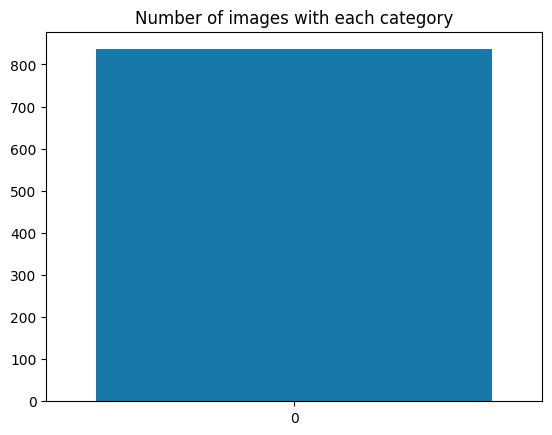

{0: 'boat'}


In [13]:
cat_stats = {id : len(imgs) for id, imgs in data.catToImgs.items()}

sns.set_palette("winter", len(cat_stats))
sns.barplot(x=list(cat_stats.keys()), y= list(cat_stats.values())).set(title='Number of images with each category')
plt.show()
print(CLASSES)

In [14]:
#image_ids = ['CAM00_img046','CAM00_img054', 'CAM00_img055', 'CAM00_img065'] 
#images_path = './hurtigruten/images/'

#for image_id in image_ids:
#    data.visualizeImage(image_id, IMAGES_PATH, image_type='.jpg')

2023-05-12_1427_dnv_scenario1_full_00_000_AfternoonClear_absoluteCalmBlueSea


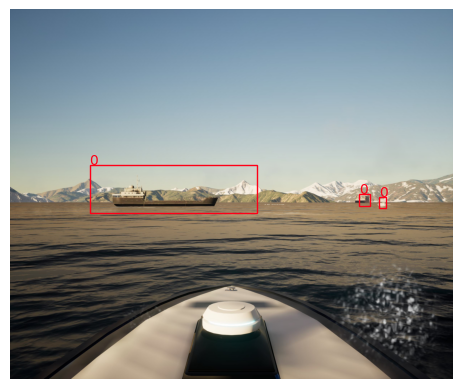

[{'area': 4260, 'iscrowd': 0, 'bbox': [1942, 1024, 60, 71], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_0'}, {'area': 251100, 'iscrowd': 0, 'bbox': [442, 863, 930, 270], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_1'}, {'area': 2294, 'iscrowd': 0, 'bbox': [2052, 1041, 37, 62], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_2'}]
2023-05-12_1429_dnv_scenario1_full_00_000_AfternoonCloudy_absoluteCalmBlueSea


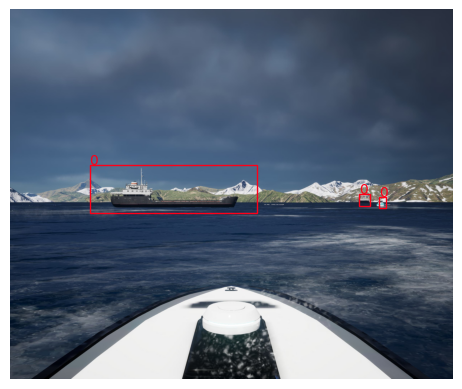

[{'area': 4260, 'iscrowd': 0, 'bbox': [1942, 1024, 60, 71], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_0'}, {'area': 251100, 'iscrowd': 0, 'bbox': [442, 863, 930, 270], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_1'}, {'area': 2294, 'iscrowd': 0, 'bbox': [2052, 1041, 37, 62], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_2'}]
2023-05-12_1431_dnv_scenario1_full_00_000_AfternoonCloudy_Rain_absoluteCalmBlueSea


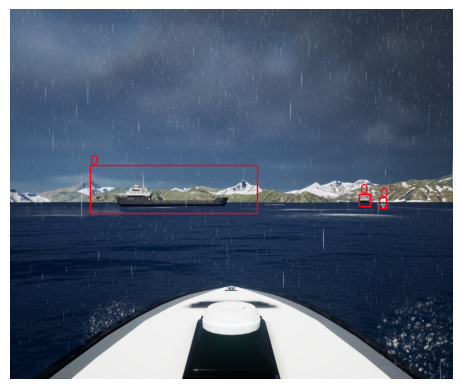

[{'area': 4260, 'iscrowd': 0, 'bbox': [1942, 1024, 60, 71], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_0'}, {'area': 251100, 'iscrowd': 0, 'bbox': [442, 863, 930, 270], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_1'}, {'area': 2294, 'iscrowd': 0, 'bbox': [2052, 1041, 37, 62], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_2'}]
2023-05-12_1437_dnv_scenario1_full_00_000_EveningClear_absoluteCalmBlueSea


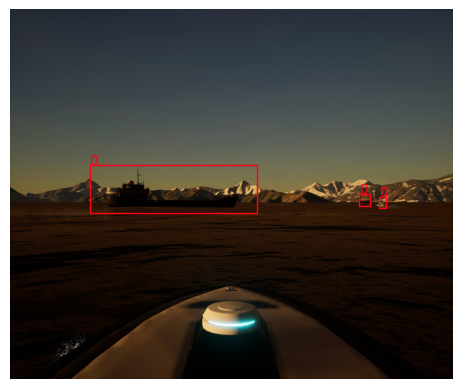

[{'area': 4260, 'iscrowd': 0, 'bbox': [1942, 1024, 60, 71], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_0'}, {'area': 251100, 'iscrowd': 0, 'bbox': [442, 863, 930, 270], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_1'}, {'area': 2294, 'iscrowd': 0, 'bbox': [2052, 1041, 37, 62], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_2'}]
2023-05-12_1439_dnv_scenario1_full_00_000_EveningCloudy_absoluteCalmBlueSea


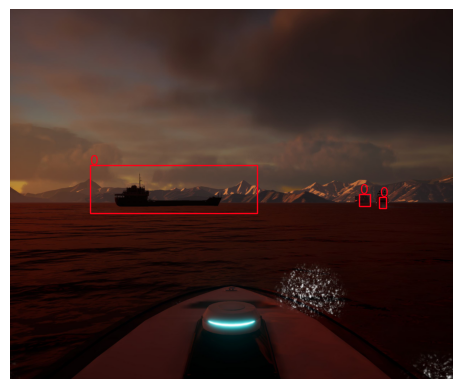

[{'area': 4260, 'iscrowd': 0, 'bbox': [1942, 1024, 60, 71], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_0'}, {'area': 251100, 'iscrowd': 0, 'bbox': [442, 863, 930, 270], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_1'}, {'area': 2294, 'iscrowd': 0, 'bbox': [2052, 1041, 37, 62], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_2'}]
2023-05-12_1442_dnv_scenario1_full_00_000_EveningCloudy_Rain_absoluteCalmBlueSea


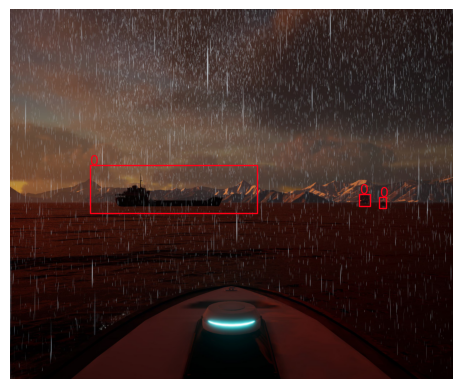

[{'area': 4260, 'iscrowd': 0, 'bbox': [1942, 1024, 60, 71], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_0'}, {'area': 251100, 'iscrowd': 0, 'bbox': [442, 863, 930, 270], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_1'}, {'area': 2294, 'iscrowd': 0, 'bbox': [2052, 1041, 37, 62], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_2'}]
2023-05-12_1444_dnv_scenario1_full_00_000_FoggyClear_absoluteCalmBlueSea


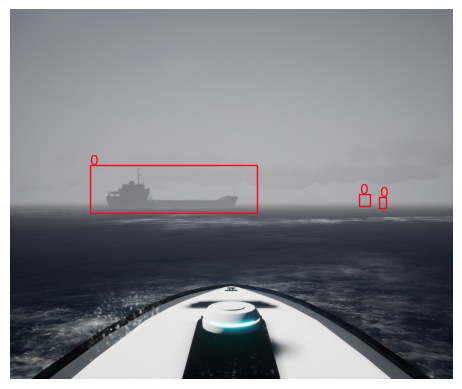

[{'area': 4260, 'iscrowd': 0, 'bbox': [1942, 1024, 60, 71], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_0'}, {'area': 251100, 'iscrowd': 0, 'bbox': [442, 863, 930, 270], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_1'}, {'area': 2294, 'iscrowd': 0, 'bbox': [2052, 1041, 37, 62], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_2'}]
2023-05-12_1446_dnv_scenario1_full_00_000_FoggyCloudy_absoluteCalmBlueSea


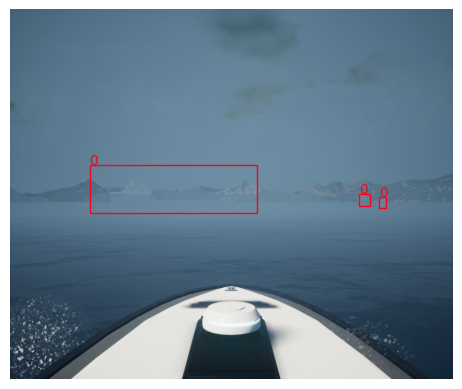

[{'area': 4260, 'iscrowd': 0, 'bbox': [1942, 1024, 60, 71], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_0'}, {'area': 251100, 'iscrowd': 0, 'bbox': [442, 863, 930, 270], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_1'}, {'area': 2294, 'iscrowd': 0, 'bbox': [2052, 1041, 37, 62], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_2'}]
2023-05-12_1450_dnv_scenario1_full_00_000_MorningCloudy_absoluteCalmBlueSea


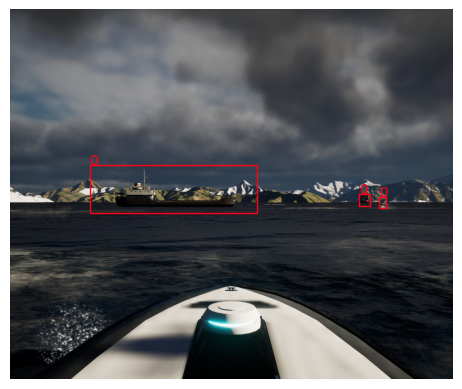

[{'area': 4260, 'iscrowd': 0, 'bbox': [1942, 1024, 60, 71], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_0'}, {'area': 251100, 'iscrowd': 0, 'bbox': [442, 863, 930, 270], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_1'}, {'area': 2294, 'iscrowd': 0, 'bbox': [2052, 1041, 37, 62], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_2'}]
2023-05-12_1448_dnv_scenario1_full_00_000_MorningClear_absoluteCalmBlueSea


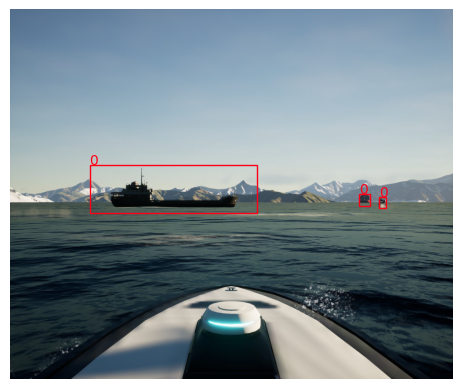

[{'area': 4260, 'iscrowd': 0, 'bbox': [1942, 1024, 60, 71], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_0'}, {'area': 251100, 'iscrowd': 0, 'bbox': [442, 863, 930, 270], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_1'}, {'area': 2294, 'iscrowd': 0, 'bbox': [2052, 1041, 37, 62], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_2'}]
2023-05-12_1452_dnv_scenario1_full_00_000_NightClear_absoluteCalmBlueSea


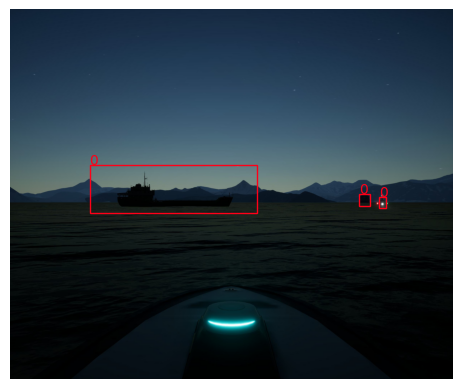

[{'area': 4260, 'iscrowd': 0, 'bbox': [1942, 1024, 60, 71], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_0'}, {'area': 251100, 'iscrowd': 0, 'bbox': [442, 863, 930, 270], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_1'}, {'area': 2294, 'iscrowd': 0, 'bbox': [2052, 1041, 37, 62], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_2'}]
2023-05-12_1454_dnv_scenario1_full_00_000_NightCloudy_absoluteCalmBlueSea


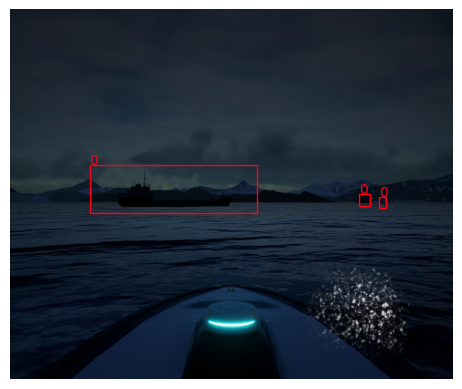

[{'area': 4260, 'iscrowd': 0, 'bbox': [1942, 1024, 60, 71], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_0'}, {'area': 251100, 'iscrowd': 0, 'bbox': [442, 863, 930, 270], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_1'}, {'area': 2294, 'iscrowd': 0, 'bbox': [2052, 1041, 37, 62], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_2'}]
2023-05-12_1456_dnv_scenario1_full_00_000_NoonClear_absoluteCalmBlueSea


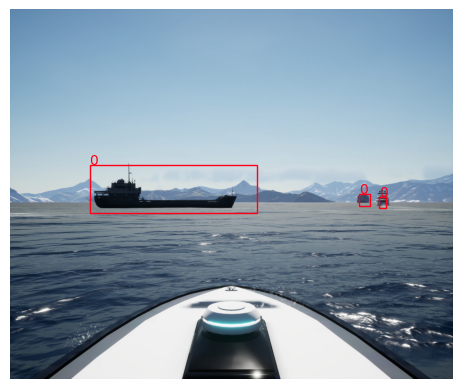

[{'area': 4260, 'iscrowd': 0, 'bbox': [1942, 1024, 60, 71], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_0'}, {'area': 251100, 'iscrowd': 0, 'bbox': [442, 863, 930, 270], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_1'}, {'area': 2294, 'iscrowd': 0, 'bbox': [2052, 1041, 37, 62], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_2'}]
2023-05-12_1458_dnv_scenario1_full_00_000_NoonCloudy_absoluteCalmBlueSea


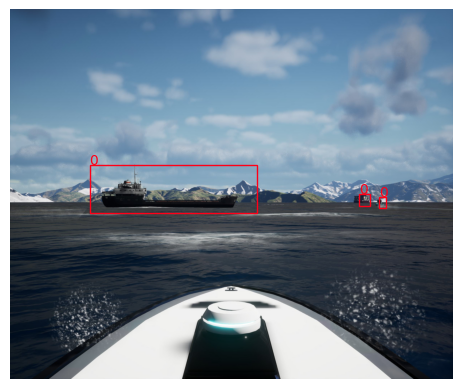

[{'area': 4260, 'iscrowd': 0, 'bbox': [1942, 1024, 60, 71], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_0'}, {'area': 251100, 'iscrowd': 0, 'bbox': [442, 863, 930, 270], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_1'}, {'area': 2294, 'iscrowd': 0, 'bbox': [2052, 1041, 37, 62], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_2'}]
2023-05-12_1500_dnv_scenario1_full_00_000_NoonCloudy_Rain_absoluteCalmBlueSea


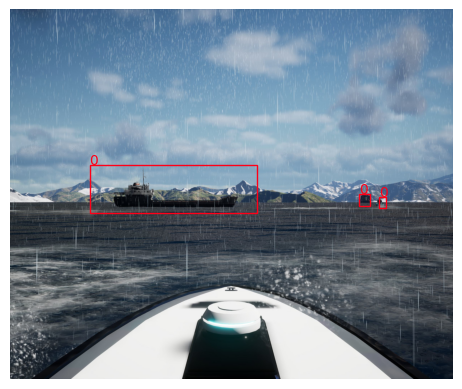

[{'area': 4260, 'iscrowd': 0, 'bbox': [1942, 1024, 60, 71], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_0'}, {'area': 251100, 'iscrowd': 0, 'bbox': [442, 863, 930, 270], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_1'}, {'area': 2294, 'iscrowd': 0, 'bbox': [2052, 1041, 37, 62], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_2'}]
2023-05-12_1502_dnv_scenario1_full_00_000_Overcast_absoluteCalmBlueSea


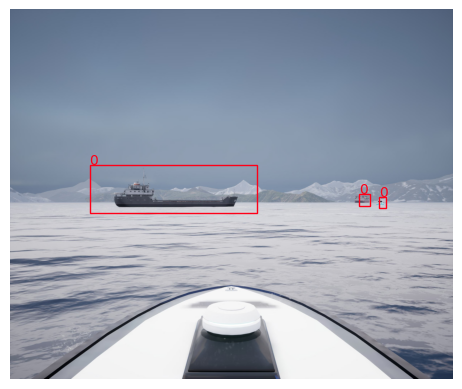

[{'area': 4260, 'iscrowd': 0, 'bbox': [1942, 1024, 60, 71], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_0'}, {'area': 251100, 'iscrowd': 0, 'bbox': [442, 863, 930, 270], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_1'}, {'area': 2294, 'iscrowd': 0, 'bbox': [2052, 1041, 37, 62], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_2'}]
2023-05-12_1504_dnv_scenario1_full_00_000_OvercastRandomize_absoluteCalmBlueSea


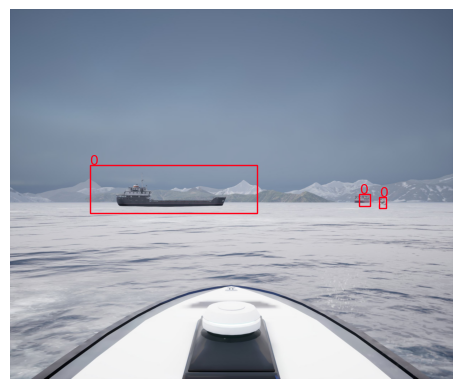

[{'area': 4260, 'iscrowd': 0, 'bbox': [1942, 1024, 60, 71], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_0'}, {'area': 251100, 'iscrowd': 0, 'bbox': [442, 863, 930, 270], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_1'}, {'area': 2294, 'iscrowd': 0, 'bbox': [2052, 1041, 37, 62], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_2'}]
2023-05-12_1506_dnv_scenario1_full_00_000_StormClouds_absoluteCalmBlueSea


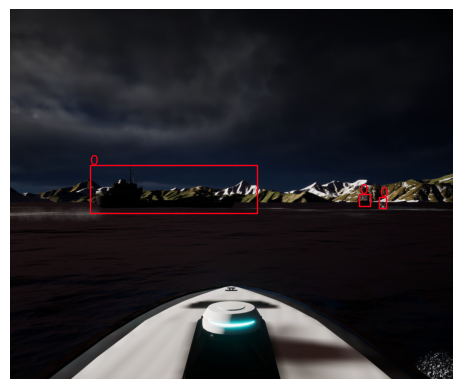

[{'area': 4260, 'iscrowd': 0, 'bbox': [1942, 1024, 60, 71], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_0'}, {'area': 251100, 'iscrowd': 0, 'bbox': [442, 863, 930, 270], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_1'}, {'area': 2294, 'iscrowd': 0, 'bbox': [2052, 1041, 37, 62], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_2'}]
2023-05-12_1508_dnv_scenario1_full_00_000_StormyClouds_Rain_absoluteCalmBlueSea


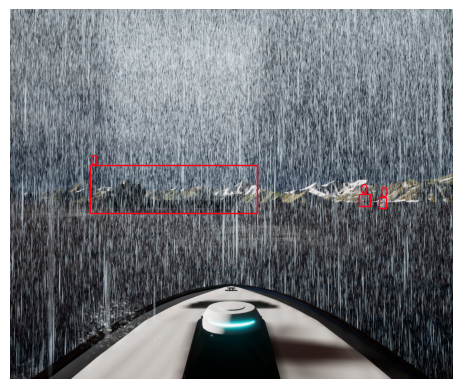

[{'area': 4260, 'iscrowd': 0, 'bbox': [1942, 1024, 60, 71], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_0'}, {'area': 251100, 'iscrowd': 0, 'bbox': [442, 863, 930, 270], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_1'}, {'area': 2294, 'iscrowd': 0, 'bbox': [2052, 1041, 37, 62], 'category_id': 0, 'segmentation': [], 'image_id': 'CAM00_img028', 'id': 'CAM00_img028_2'}]


In [15]:
image_id = 'CAM00_img028'
#image_id = 'CAM00_img038'
anns = []

for scenario in SIMULATION_SCENARIOS:
    print(scenario)
    folder_path = os.path.join(DATASET_DIR, scenario)
    image_path = os.path.join(folder_path, 'images/')
    data.visualizeImage(image_id, image_path, image_type='.jpg')
    ann = data.loadAnns(data.getAnnIds(image_id))
    print(ann)
    anns.append(ann)